# Plot gridded thunderstorm days

### How the analysis grid was generated

In [1]:
from grl2022.mapping.geog import generate_grids
import geopandas as gpd

conus = gpd.read_file("../data/geog/CONUS.shp")
econus = gpd.read_file("../data/geog/econus.shp")

conus = conus.to_crs("ESRI:102003")

grids, x_, y_ = generate_grids(conus, 80000, 'ESRI:102003', returnxy=True)

# Display the empty grids

<AxesSubplot:>

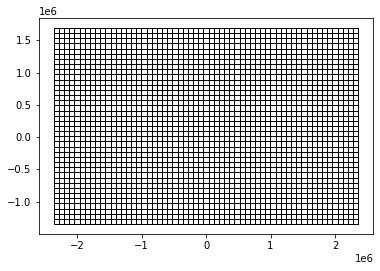

In [2]:
grids.plot(facecolor='none', edgecolor='k')

# Extract the sub regions 

<AxesSubplot:>

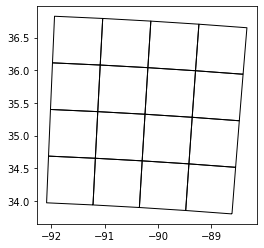

In [3]:
from grl2022.mapping.geog import generate_regions

sel_grids = generate_regions(grids)

sel_grids['mph'].plot(facecolor='none', edgecolor='k')

# Get the lat/lon meshgrid for 'grids'

In [4]:
from grl2022.mapping.geog import get_grid_mesh

gx, gy = get_grid_mesh(x_, y_)

# Read in mean seasonal counts of thunderstorm days

In [5]:
import xarray as xr

hist = xr.open_mfdataset("../data/days/HIST_*_*_grid_days.nc", combine='by_coords')
rcp45 = xr.open_mfdataset("../data/days/FUTR45_*_*_grid_days.nc", combine='by_coords')
rcp85 = xr.open_mfdataset("../data/days/FUTR85_*_*_grid_days.nc", combine='by_coords')

hist

<xarray.Dataset>
Dimensions:       (time: 60, y: 38, x: 59)
Coordinates:
  * y             (y) float64 -1.308e+06 -1.228e+06 ... 1.572e+06 1.652e+06
  * x             (x) float64 -2.322e+06 -2.242e+06 ... 2.238e+06 2.318e+06
  * time          (time) datetime64[ns] 1990-10-01 1990-12-01 ... 2005-06-01
Data variables:
    40_dbz_count  (time, y, x) float64 dask.array<chunksize=(1, 38, 59), meta=np.ndarray>
    50_dbz_count  (time, y, x) float64 dask.array<chunksize=(1, 38, 59), meta=np.ndarray>
    60_dbz_count  (time, y, x) float64 dask.array<chunksize=(1, 38, 59), meta=np.ndarray>
Attributes: (12/17)
    TITLE:                        OUTPUT FROM WRF V4.1.2 MODEL
    WEST-EAST_GRID_DIMENSION:    1400
    SOUTH-NORTH_GRID_DIMENSION:  900
    DX:                          3750.0
    DY:                          3750.0
    DT:                          20.0
    ...                          ...
    STAND_LON:                   -97.5
    POLE_LAT:                    90.0
    POLE_LON:                    0.0
    MAP_PROJ:                    1
    MAP_PROJ_CHAR:               Lambert Conformal
    description:                 Mean SON 40/50/60 dBZ grid days Retrospectiv...

# Plotting setup

In [6]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from grl2022.mapping.ax import setup_map
from grl2022.mapping.colors import get_cmap

titles = {'HIST': {"title": "{} {} dBZ Grid Days", "clabel": 'Days'},
          'FUTR 4.5': {"title": "{} Change in {} dBZ Grid Days", "clabel": '$\Delta$Days'},
          'FUTR 8.5': {"title": "{} Change in {} dBZ Grid Days", "clabel": '$\Delta$Days'}}

# Map the data for DJF grid counts

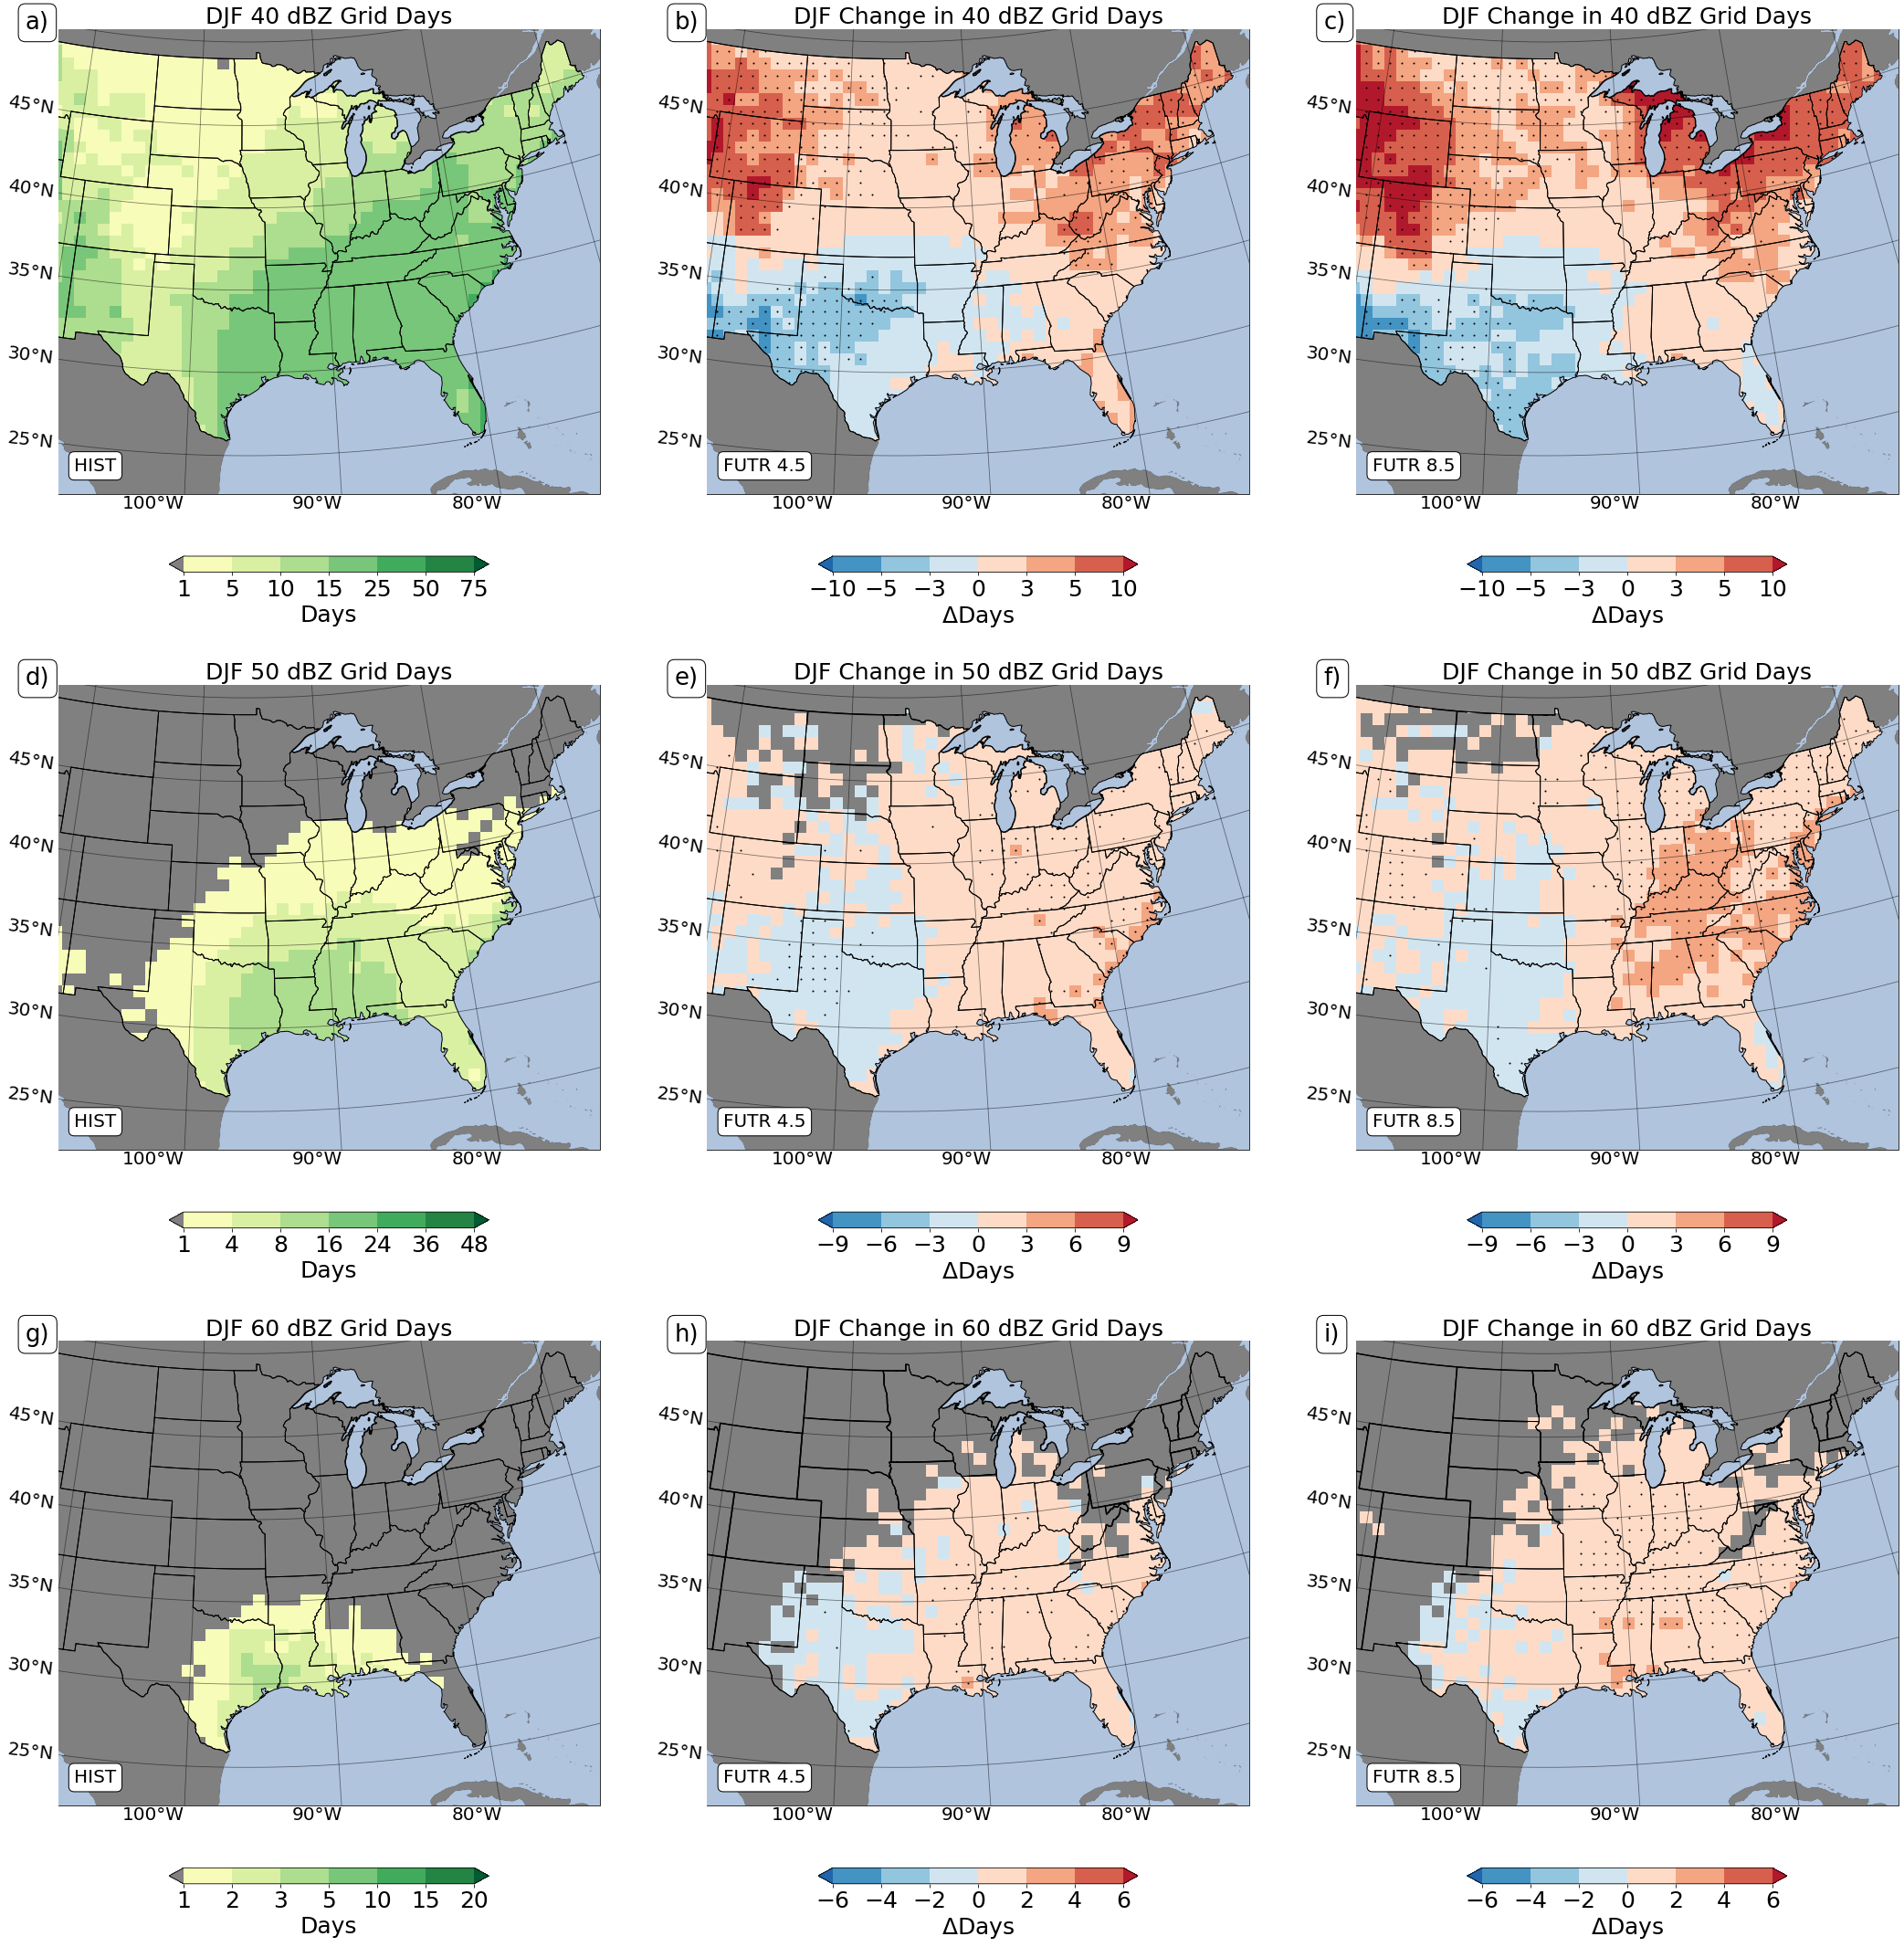

In [7]:
import numpy as np
import cartopy.crs as ccrs
from grl2022.mapping.geog import grid_significance

plt.rcParams['figure.figsize'] = 30, 40

season = 'DJF'

hist_s = hist.where(hist.time.dt.season==season, drop=True)
rcp45_s = rcp45.where(rcp45.time.dt.season==season, drop=True)
rcp85_s = rcp85.where(rcp85.time.dt.season==season, drop=True)

for row, dbz in enumerate([40, 50, 60]):
    
    hist_dbz_ind = hist_s[f'{dbz}_dbz_count']
    rcp45_dbz_ind = rcp45_s[f'{dbz}_dbz_count']
    rcp85_dbz_ind = rcp85_s[f'{dbz}_dbz_count']
    
    pts45 = np.where(grid_significance(hist_dbz_ind.values, rcp45_dbz_ind.values) < 0.05)
    pts85 = np.where(grid_significance(hist_dbz_ind.values, rcp85_dbz_ind.values) < 0.05)
    
    hist_dbz = hist_dbz_ind.mean('time')
    rcp45_dbz = rcp45_dbz_ind.mean('time')
    rcp85_dbz = rcp85_dbz_ind.mean('time')

    rcp45_diff = rcp45_dbz - hist_dbz
    rcp85_diff = rcp85_dbz - hist_dbz

    rcp45_diff = np.ma.masked_where((rcp45_dbz==0) & (hist_dbz==0), rcp45_diff)
    rcp85_diff = np.ma.masked_where((rcp85_dbz==0) & (hist_dbz==0), rcp85_diff)


    sig = {'HIST': {'x': [], 'y': []}}
    sig['FUTR 4.5'] = {'x': gx[pts45], 'y': gy[pts45]}
    sig['FUTR 8.5'] = {'x': gx[pts85], 'y': gy[pts85]}

    for col, (name, sim) in enumerate(zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], 
                                          [hist_dbz, rcp45_diff, rcp85_diff])):

        ax = setup_map(row, col, 4, 3)

        ax.set_title(titles[name]['title'].format(season, dbz), fontsize=25)

        norm, cmap = get_cmap(name, f"{dbz} Grid Days Season")

        mmp = ax.pcolormesh(gx, gy, sim, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='nearest', zorder=5)
        cbar = plt.colorbar(mmp, ax=ax, shrink=0.5, pad=0.1, orientation='horizontal', extend='both', label='Days')
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label(label=titles[name]['clabel'], size=25)   

        ax.plot(sig[name]['x'], sig[name]['y'], 'k.', ms=2, transform=ccrs.PlateCarree(), zorder=5)
        
        ax.annotate(name, (0.03,0.05), xycoords='axes fraction',fontsize=20, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
    
plt.tight_layout()

plt.savefig("../figures/figS1.pdf", bbox_inches='tight', dpi=300) 

# Map the data for MAM grid counts

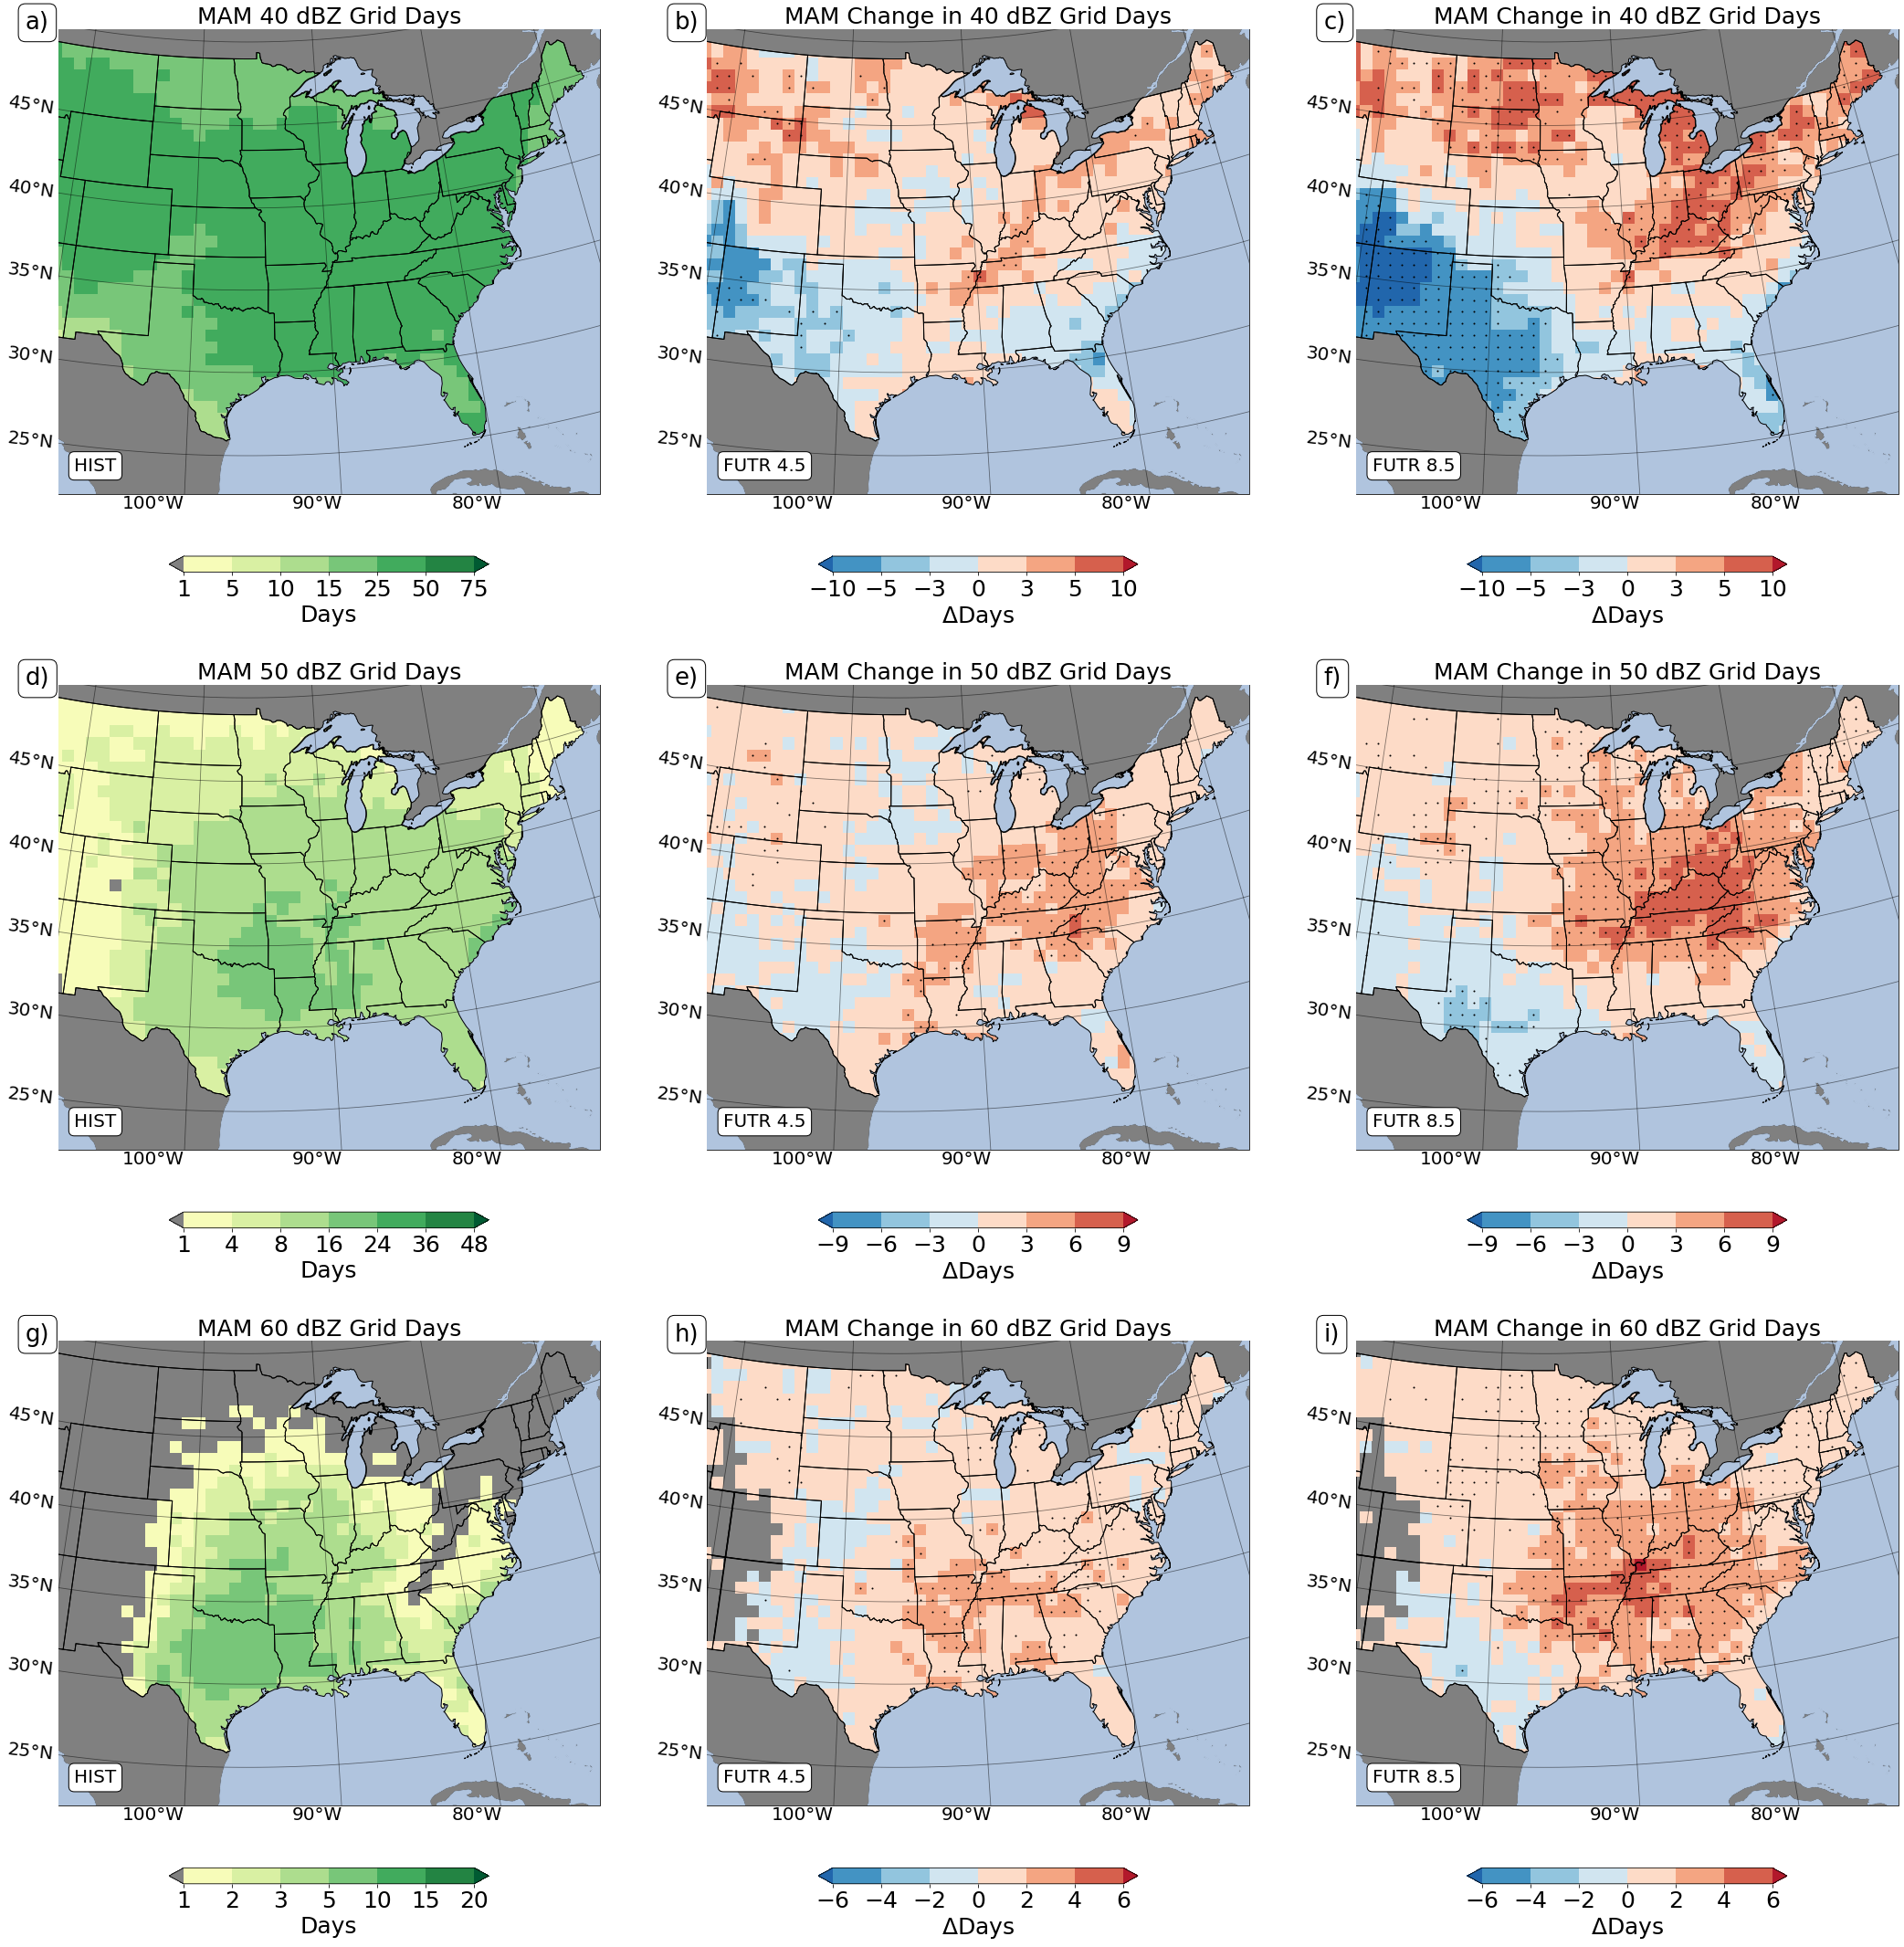

In [8]:
import numpy as np
import cartopy.crs as ccrs
from grl2022.mapping.geog import grid_significance

plt.rcParams['figure.figsize'] = 30, 40

season = 'MAM'

hist_s = hist.where(hist.time.dt.season==season, drop=True)
rcp45_s = rcp45.where(rcp45.time.dt.season==season, drop=True)
rcp85_s = rcp85.where(rcp85.time.dt.season==season, drop=True)

for row, dbz in enumerate([40, 50, 60]):
    
    hist_dbz_ind = hist_s[f'{dbz}_dbz_count']
    rcp45_dbz_ind = rcp45_s[f'{dbz}_dbz_count']
    rcp85_dbz_ind = rcp85_s[f'{dbz}_dbz_count']
    
    pts45 = np.where(grid_significance(hist_dbz_ind.values, rcp45_dbz_ind.values) < 0.05)
    pts85 = np.where(grid_significance(hist_dbz_ind.values, rcp85_dbz_ind.values) < 0.05)
    
    hist_dbz = hist_dbz_ind.mean('time')
    rcp45_dbz = rcp45_dbz_ind.mean('time')
    rcp85_dbz = rcp85_dbz_ind.mean('time')

    rcp45_diff = rcp45_dbz - hist_dbz
    rcp85_diff = rcp85_dbz - hist_dbz

    rcp45_diff = np.ma.masked_where((rcp45_dbz==0) & (hist_dbz==0), rcp45_diff)
    rcp85_diff = np.ma.masked_where((rcp85_dbz==0) & (hist_dbz==0), rcp85_diff)


    sig = {'HIST': {'x': [], 'y': []}}
    sig['FUTR 4.5'] = {'x': gx[pts45], 'y': gy[pts45]}
    sig['FUTR 8.5'] = {'x': gx[pts85], 'y': gy[pts85]}

    for col, (name, sim) in enumerate(zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], 
                                          [hist_dbz, rcp45_diff, rcp85_diff])):

        ax = setup_map(row, col, 4, 3)

        ax.set_title(titles[name]['title'].format(season, dbz), fontsize=25)

        norm, cmap = get_cmap(name, f"{dbz} Grid Days Season")

        mmp = ax.pcolormesh(gx, gy, sim, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='nearest', zorder=5)
        cbar = plt.colorbar(mmp, ax=ax, shrink=0.5, pad=0.1, orientation='horizontal', extend='both', label='Days')
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label(label=titles[name]['clabel'], size=25)   

        ax.plot(sig[name]['x'], sig[name]['y'], 'k.', ms=2, transform=ccrs.PlateCarree(), zorder=5)
        
        ax.annotate(name, (0.03,0.05), xycoords='axes fraction',fontsize=20, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
    
plt.tight_layout()

plt.savefig("../figures/figS2.pdf", bbox_inches='tight', dpi=300)

# Map the data for JJA grid counts

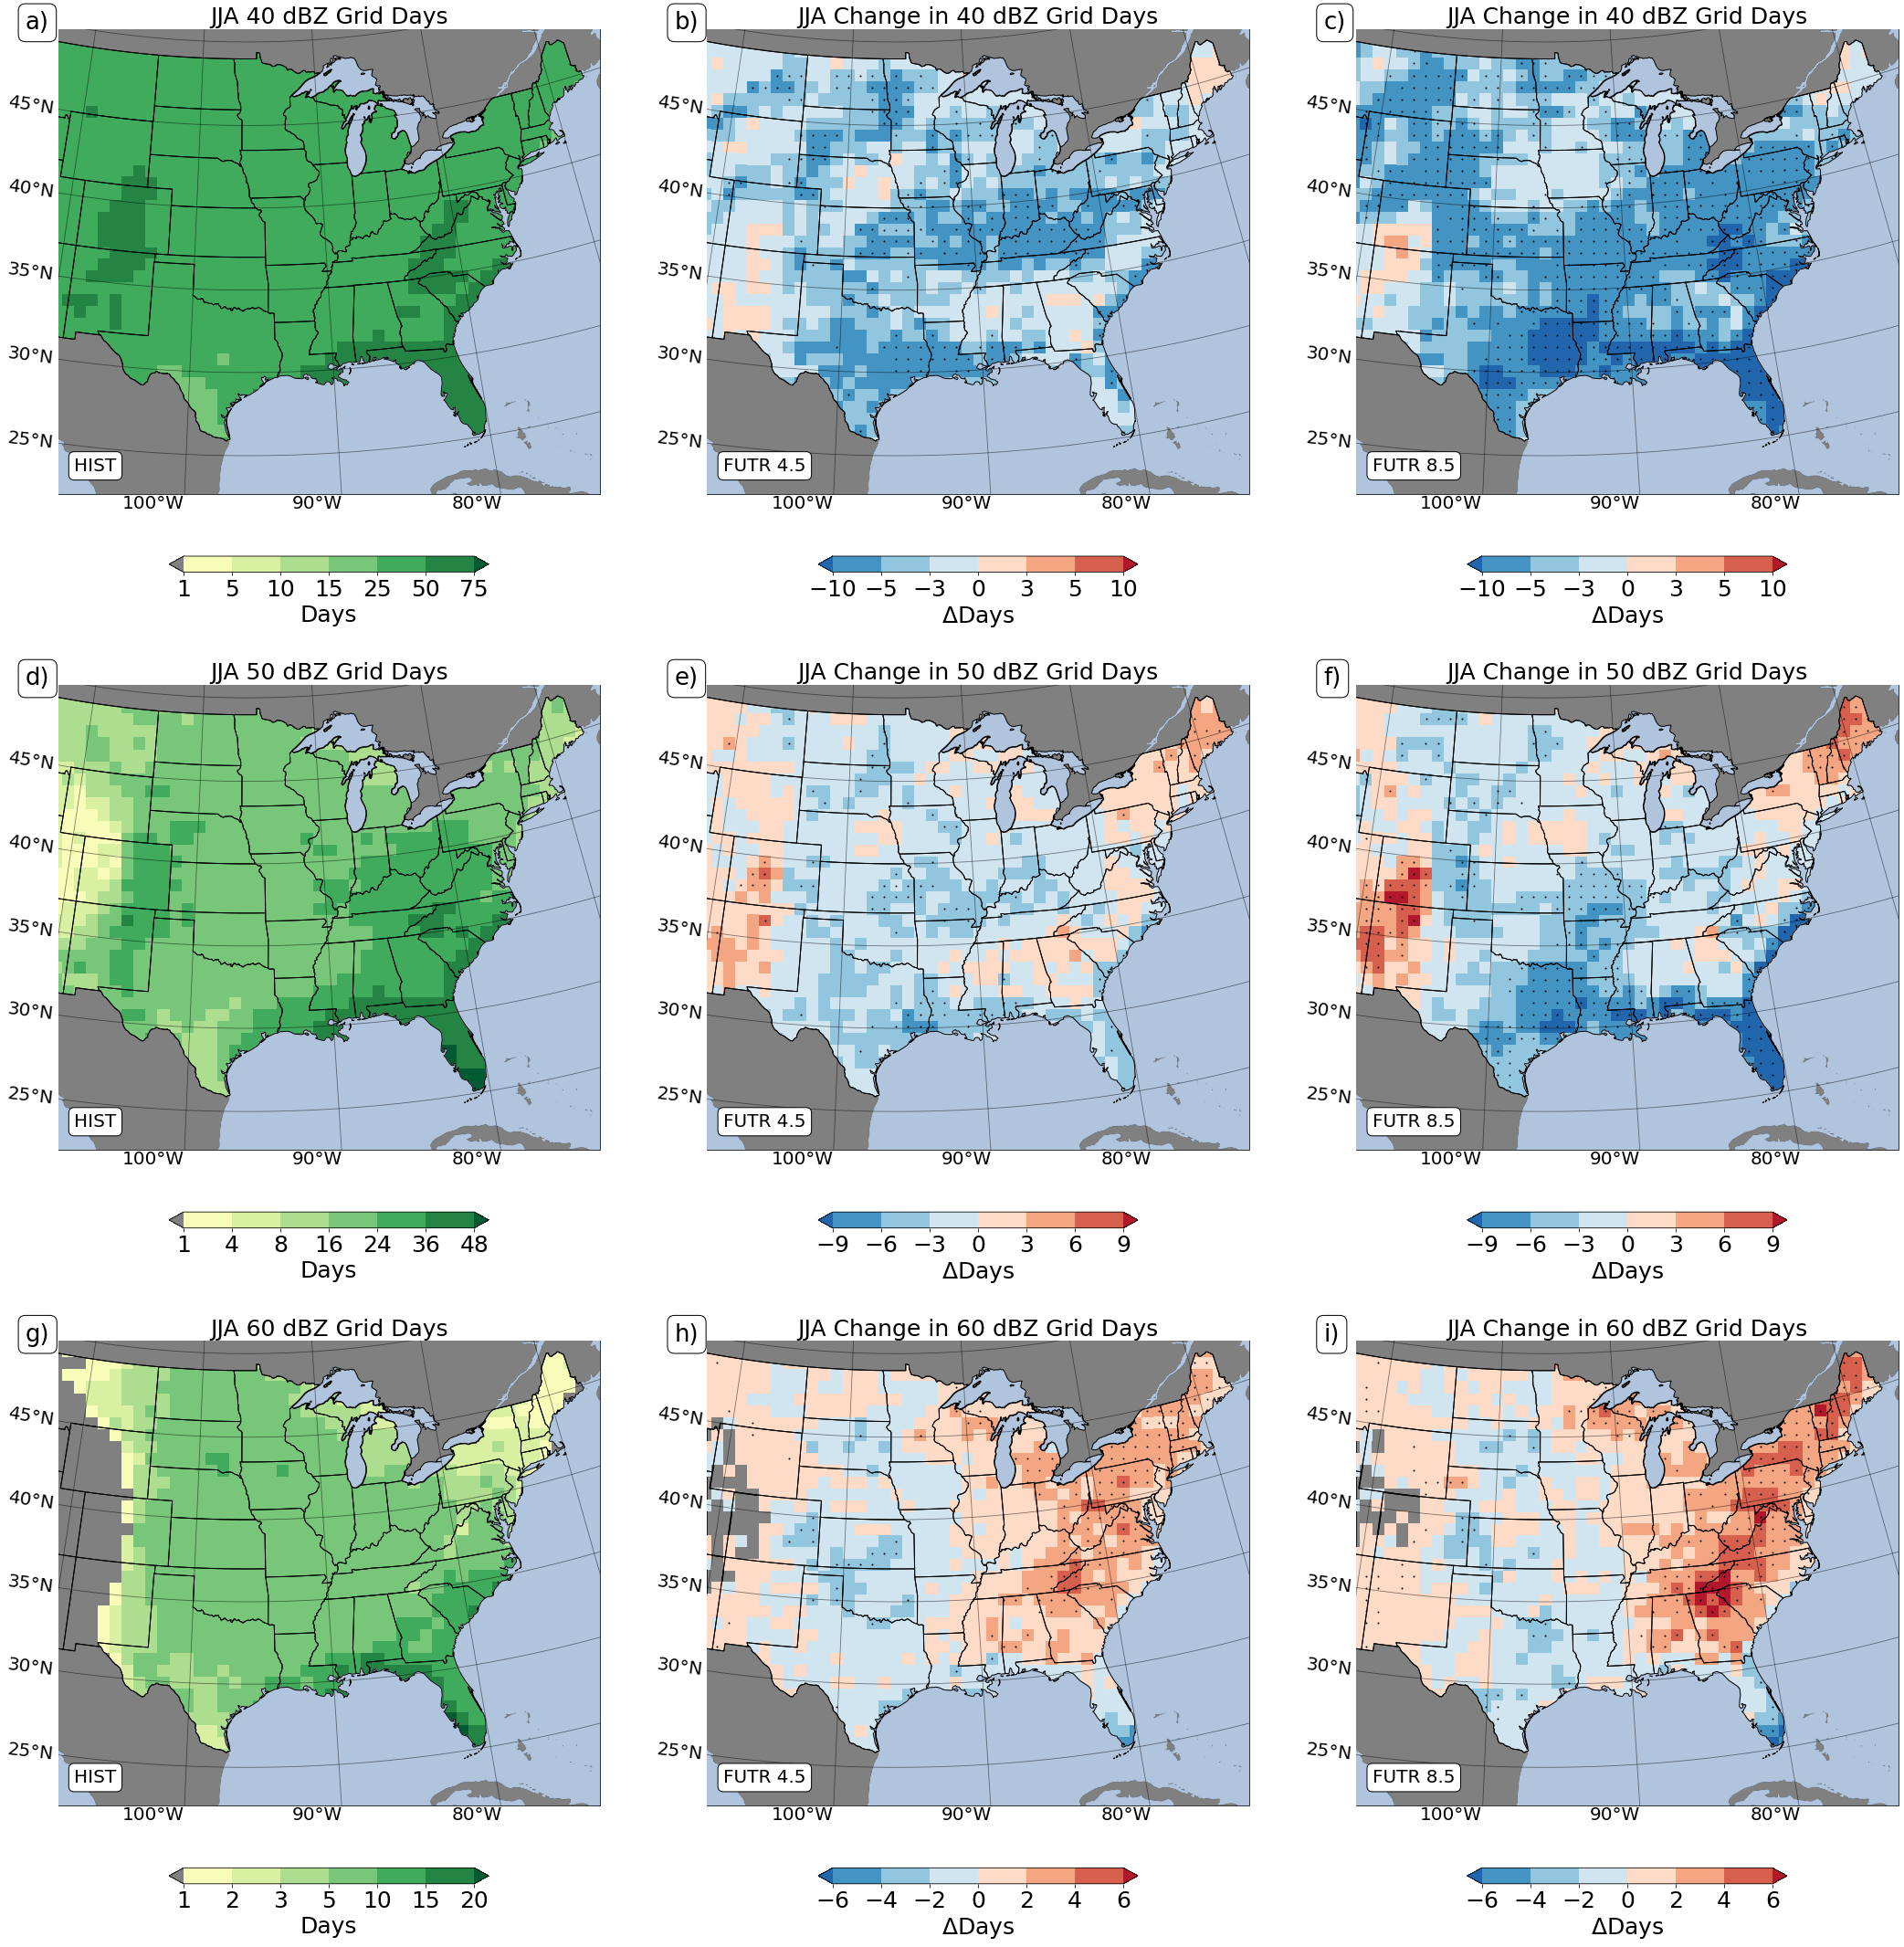

In [9]:
import numpy as np
import cartopy.crs as ccrs
from grl2022.mapping.geog import grid_significance

plt.rcParams['figure.figsize'] = 30, 40

season = 'JJA'

hist_s = hist.where(hist.time.dt.season==season, drop=True)
rcp45_s = rcp45.where(rcp45.time.dt.season==season, drop=True)
rcp85_s = rcp85.where(rcp85.time.dt.season==season, drop=True)

for row, dbz in enumerate([40, 50, 60]):
    
    hist_dbz_ind = hist_s[f'{dbz}_dbz_count']
    rcp45_dbz_ind = rcp45_s[f'{dbz}_dbz_count']
    rcp85_dbz_ind = rcp85_s[f'{dbz}_dbz_count']
    
    pts45 = np.where(grid_significance(hist_dbz_ind.values, rcp45_dbz_ind.values) < 0.05)
    pts85 = np.where(grid_significance(hist_dbz_ind.values, rcp85_dbz_ind.values) < 0.05)
    
    hist_dbz = hist_dbz_ind.mean('time')
    rcp45_dbz = rcp45_dbz_ind.mean('time')
    rcp85_dbz = rcp85_dbz_ind.mean('time')

    rcp45_diff = rcp45_dbz - hist_dbz
    rcp85_diff = rcp85_dbz - hist_dbz

    rcp45_diff = np.ma.masked_where((rcp45_dbz==0) & (hist_dbz==0), rcp45_diff)
    rcp85_diff = np.ma.masked_where((rcp85_dbz==0) & (hist_dbz==0), rcp85_diff)


    sig = {'HIST': {'x': [], 'y': []}}
    sig['FUTR 4.5'] = {'x': gx[pts45], 'y': gy[pts45]}
    sig['FUTR 8.5'] = {'x': gx[pts85], 'y': gy[pts85]}

    for col, (name, sim) in enumerate(zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], 
                                          [hist_dbz, rcp45_diff, rcp85_diff])):

        ax = setup_map(row, col, 4, 3)

        ax.set_title(titles[name]['title'].format(season, dbz), fontsize=25)

        norm, cmap = get_cmap(name, f"{dbz} Grid Days Season")

        mmp = ax.pcolormesh(gx, gy, sim, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='nearest', zorder=5)
        cbar = plt.colorbar(mmp, ax=ax, shrink=0.5, pad=0.1, orientation='horizontal', extend='both', label='Days')
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label(label=titles[name]['clabel'], size=25)   

        ax.plot(sig[name]['x'], sig[name]['y'], 'k.', ms=2, transform=ccrs.PlateCarree(), zorder=5)
        
        ax.annotate(name, (0.03,0.05), xycoords='axes fraction',fontsize=20, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
    
plt.tight_layout()

plt.savefig("../figures/figS3.pdf", bbox_inches='tight', dpi=300)

# Map the data for SON grid counts

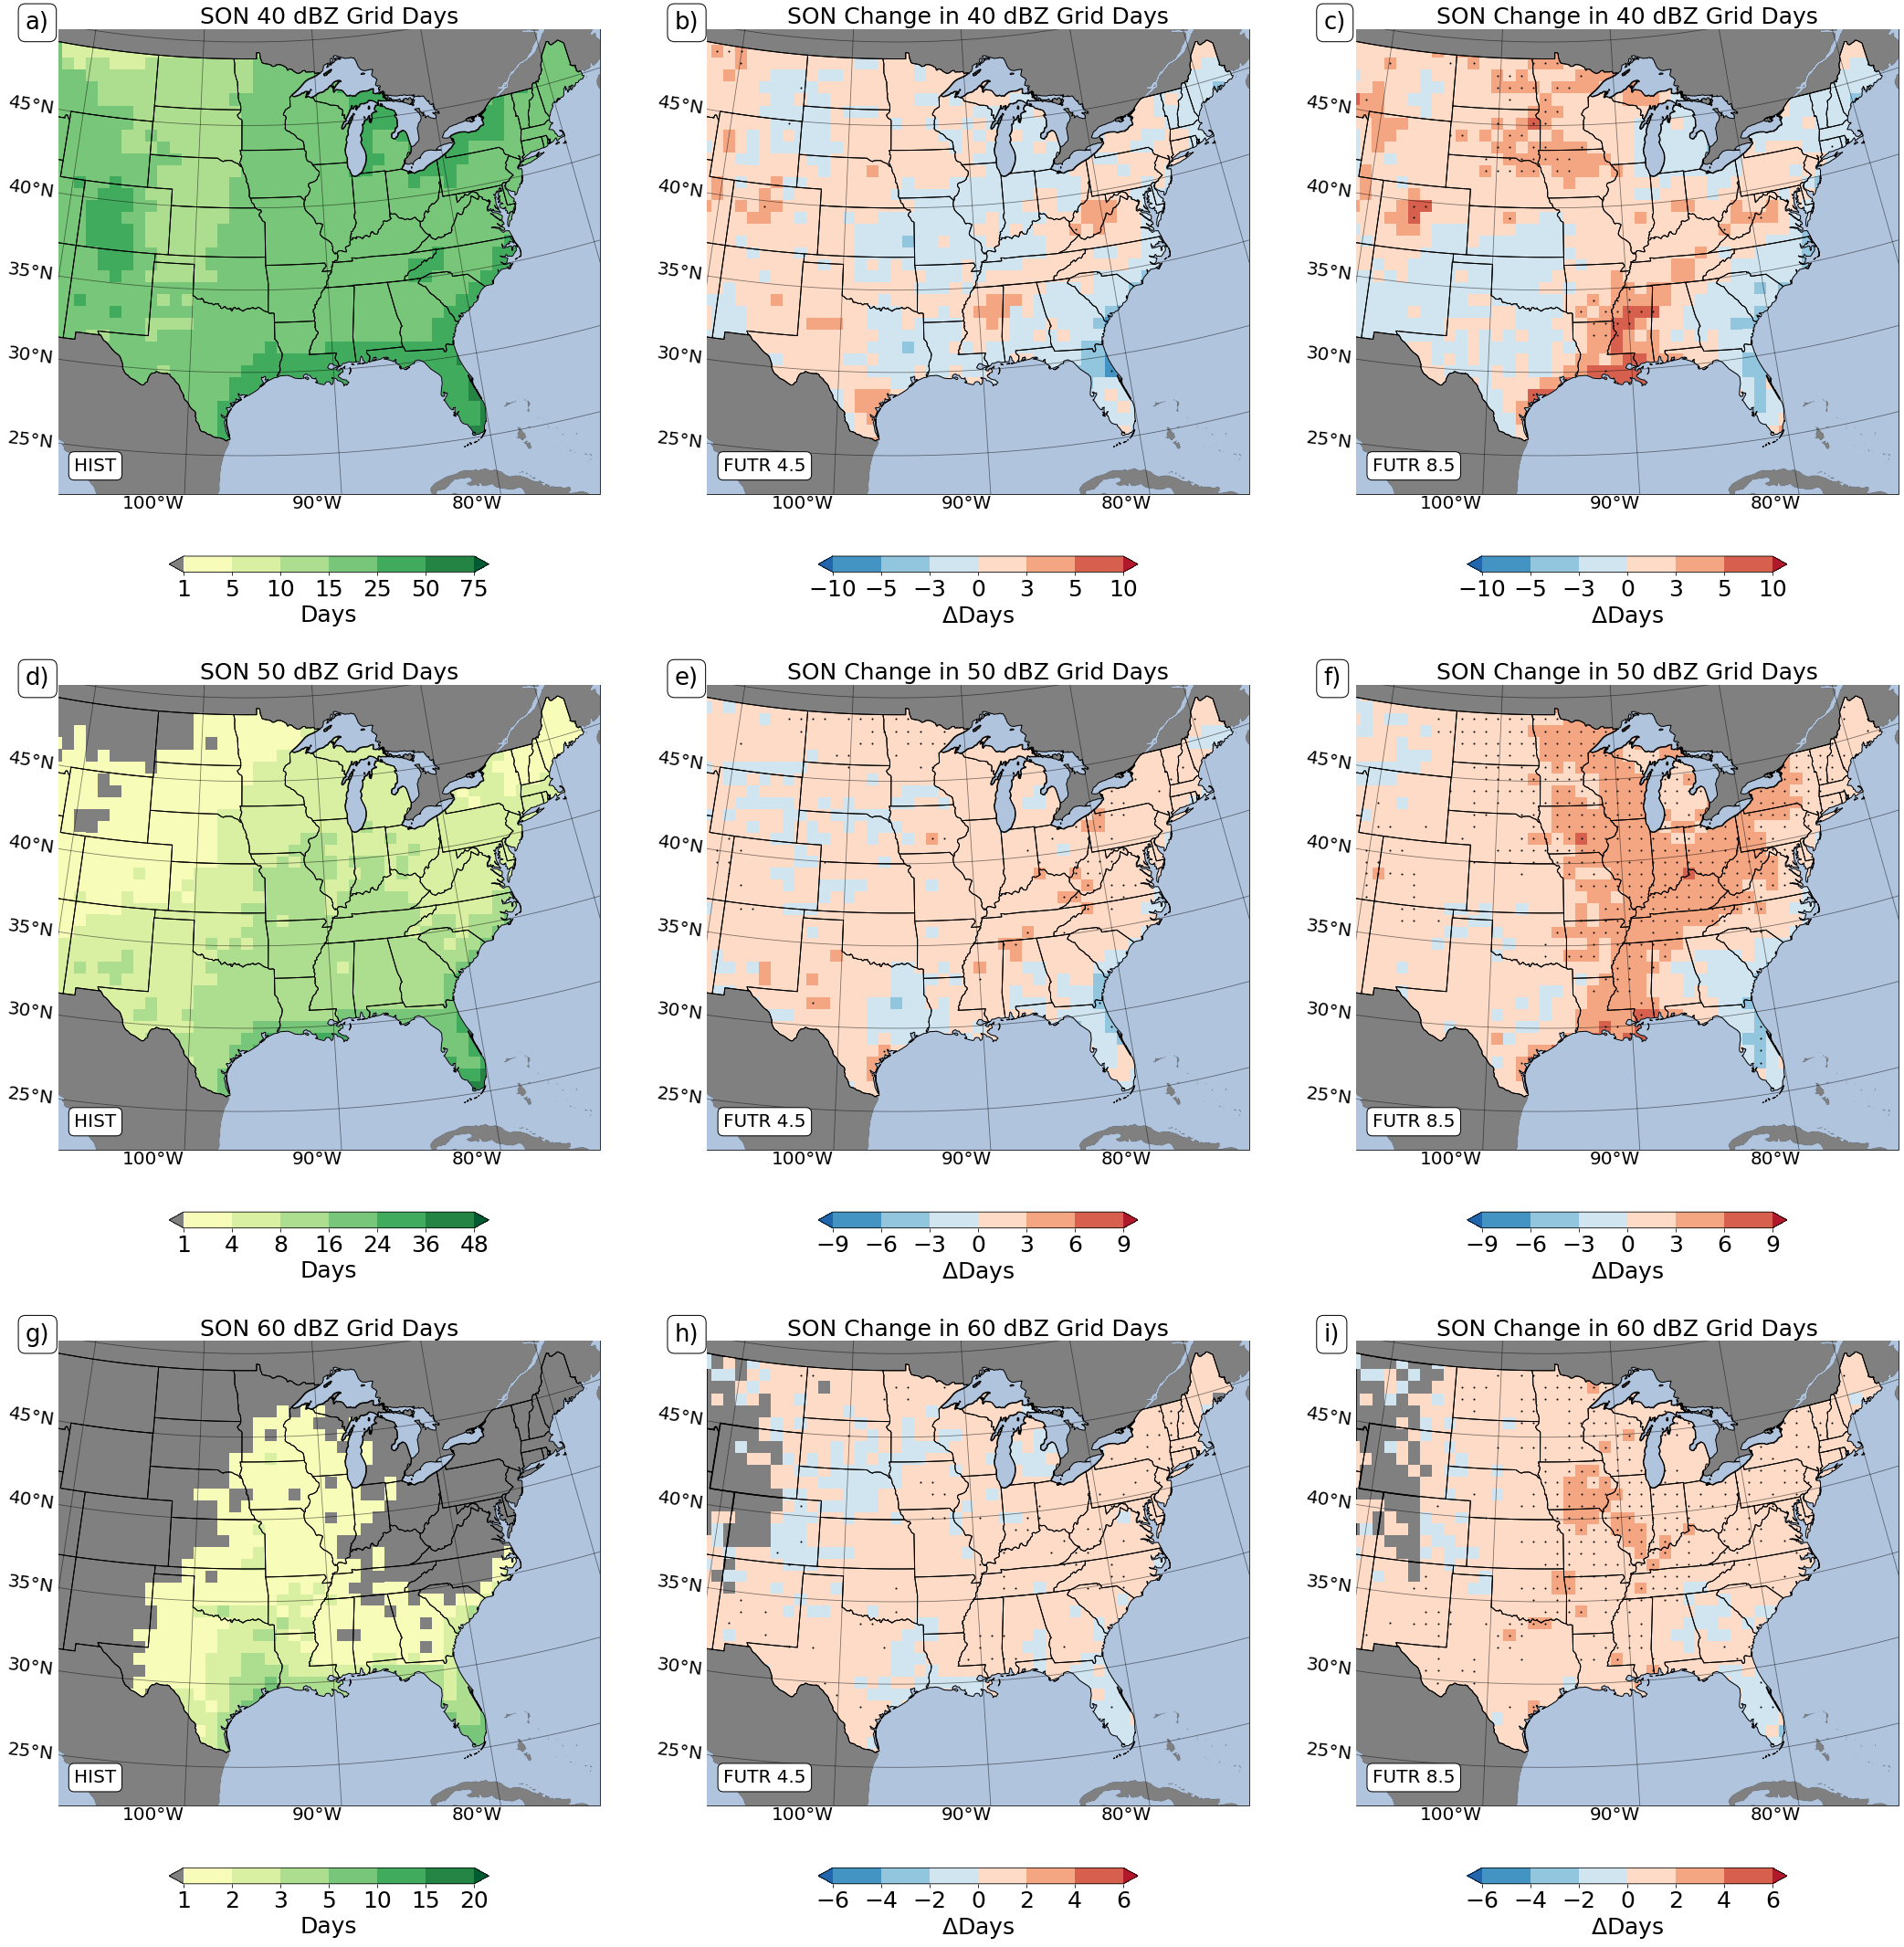

In [10]:
import numpy as np
import cartopy.crs as ccrs
from grl2022.mapping.geog import grid_significance

plt.rcParams['figure.figsize'] = 30, 40

season = 'SON'

hist_s = hist.where(hist.time.dt.season==season, drop=True)
rcp45_s = rcp45.where(rcp45.time.dt.season==season, drop=True)
rcp85_s = rcp85.where(rcp85.time.dt.season==season, drop=True)

for row, dbz in enumerate([40, 50, 60]):
    
    hist_dbz_ind = hist_s[f'{dbz}_dbz_count']
    rcp45_dbz_ind = rcp45_s[f'{dbz}_dbz_count']
    rcp85_dbz_ind = rcp85_s[f'{dbz}_dbz_count']
    
    pts45 = np.where(grid_significance(hist_dbz_ind.values, rcp45_dbz_ind.values) < 0.05)
    pts85 = np.where(grid_significance(hist_dbz_ind.values, rcp85_dbz_ind.values) < 0.05)
    
    hist_dbz = hist_dbz_ind.mean('time')
    rcp45_dbz = rcp45_dbz_ind.mean('time')
    rcp85_dbz = rcp85_dbz_ind.mean('time')

    rcp45_diff = rcp45_dbz - hist_dbz
    rcp85_diff = rcp85_dbz - hist_dbz

    rcp45_diff = np.ma.masked_where((rcp45_dbz==0) & (hist_dbz==0), rcp45_diff)
    rcp85_diff = np.ma.masked_where((rcp85_dbz==0) & (hist_dbz==0), rcp85_diff)


    sig = {'HIST': {'x': [], 'y': []}}
    sig['FUTR 4.5'] = {'x': gx[pts45], 'y': gy[pts45]}
    sig['FUTR 8.5'] = {'x': gx[pts85], 'y': gy[pts85]}

    for col, (name, sim) in enumerate(zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], 
                                          [hist_dbz, rcp45_diff, rcp85_diff])):

        ax = setup_map(row, col, 4, 3)

        ax.set_title(titles[name]['title'].format(season, dbz), fontsize=25)

        norm, cmap = get_cmap(name, f"{dbz} Grid Days Season")

        mmp = ax.pcolormesh(gx, gy, sim, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='nearest', zorder=5)
        cbar = plt.colorbar(mmp, ax=ax, shrink=0.5, pad=0.1, orientation='horizontal', extend='both', label='Days')
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label(label=titles[name]['clabel'], size=25)   

        ax.plot(sig[name]['x'], sig[name]['y'], 'k.', ms=2, transform=ccrs.PlateCarree(), zorder=5)
        
        ax.annotate(name, (0.03,0.05), xycoords='axes fraction',fontsize=20, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
    
plt.tight_layout()

plt.savefig("../figures/figS4.pdf", bbox_inches='tight', dpi=300)

# Map the data for Annual grid counts

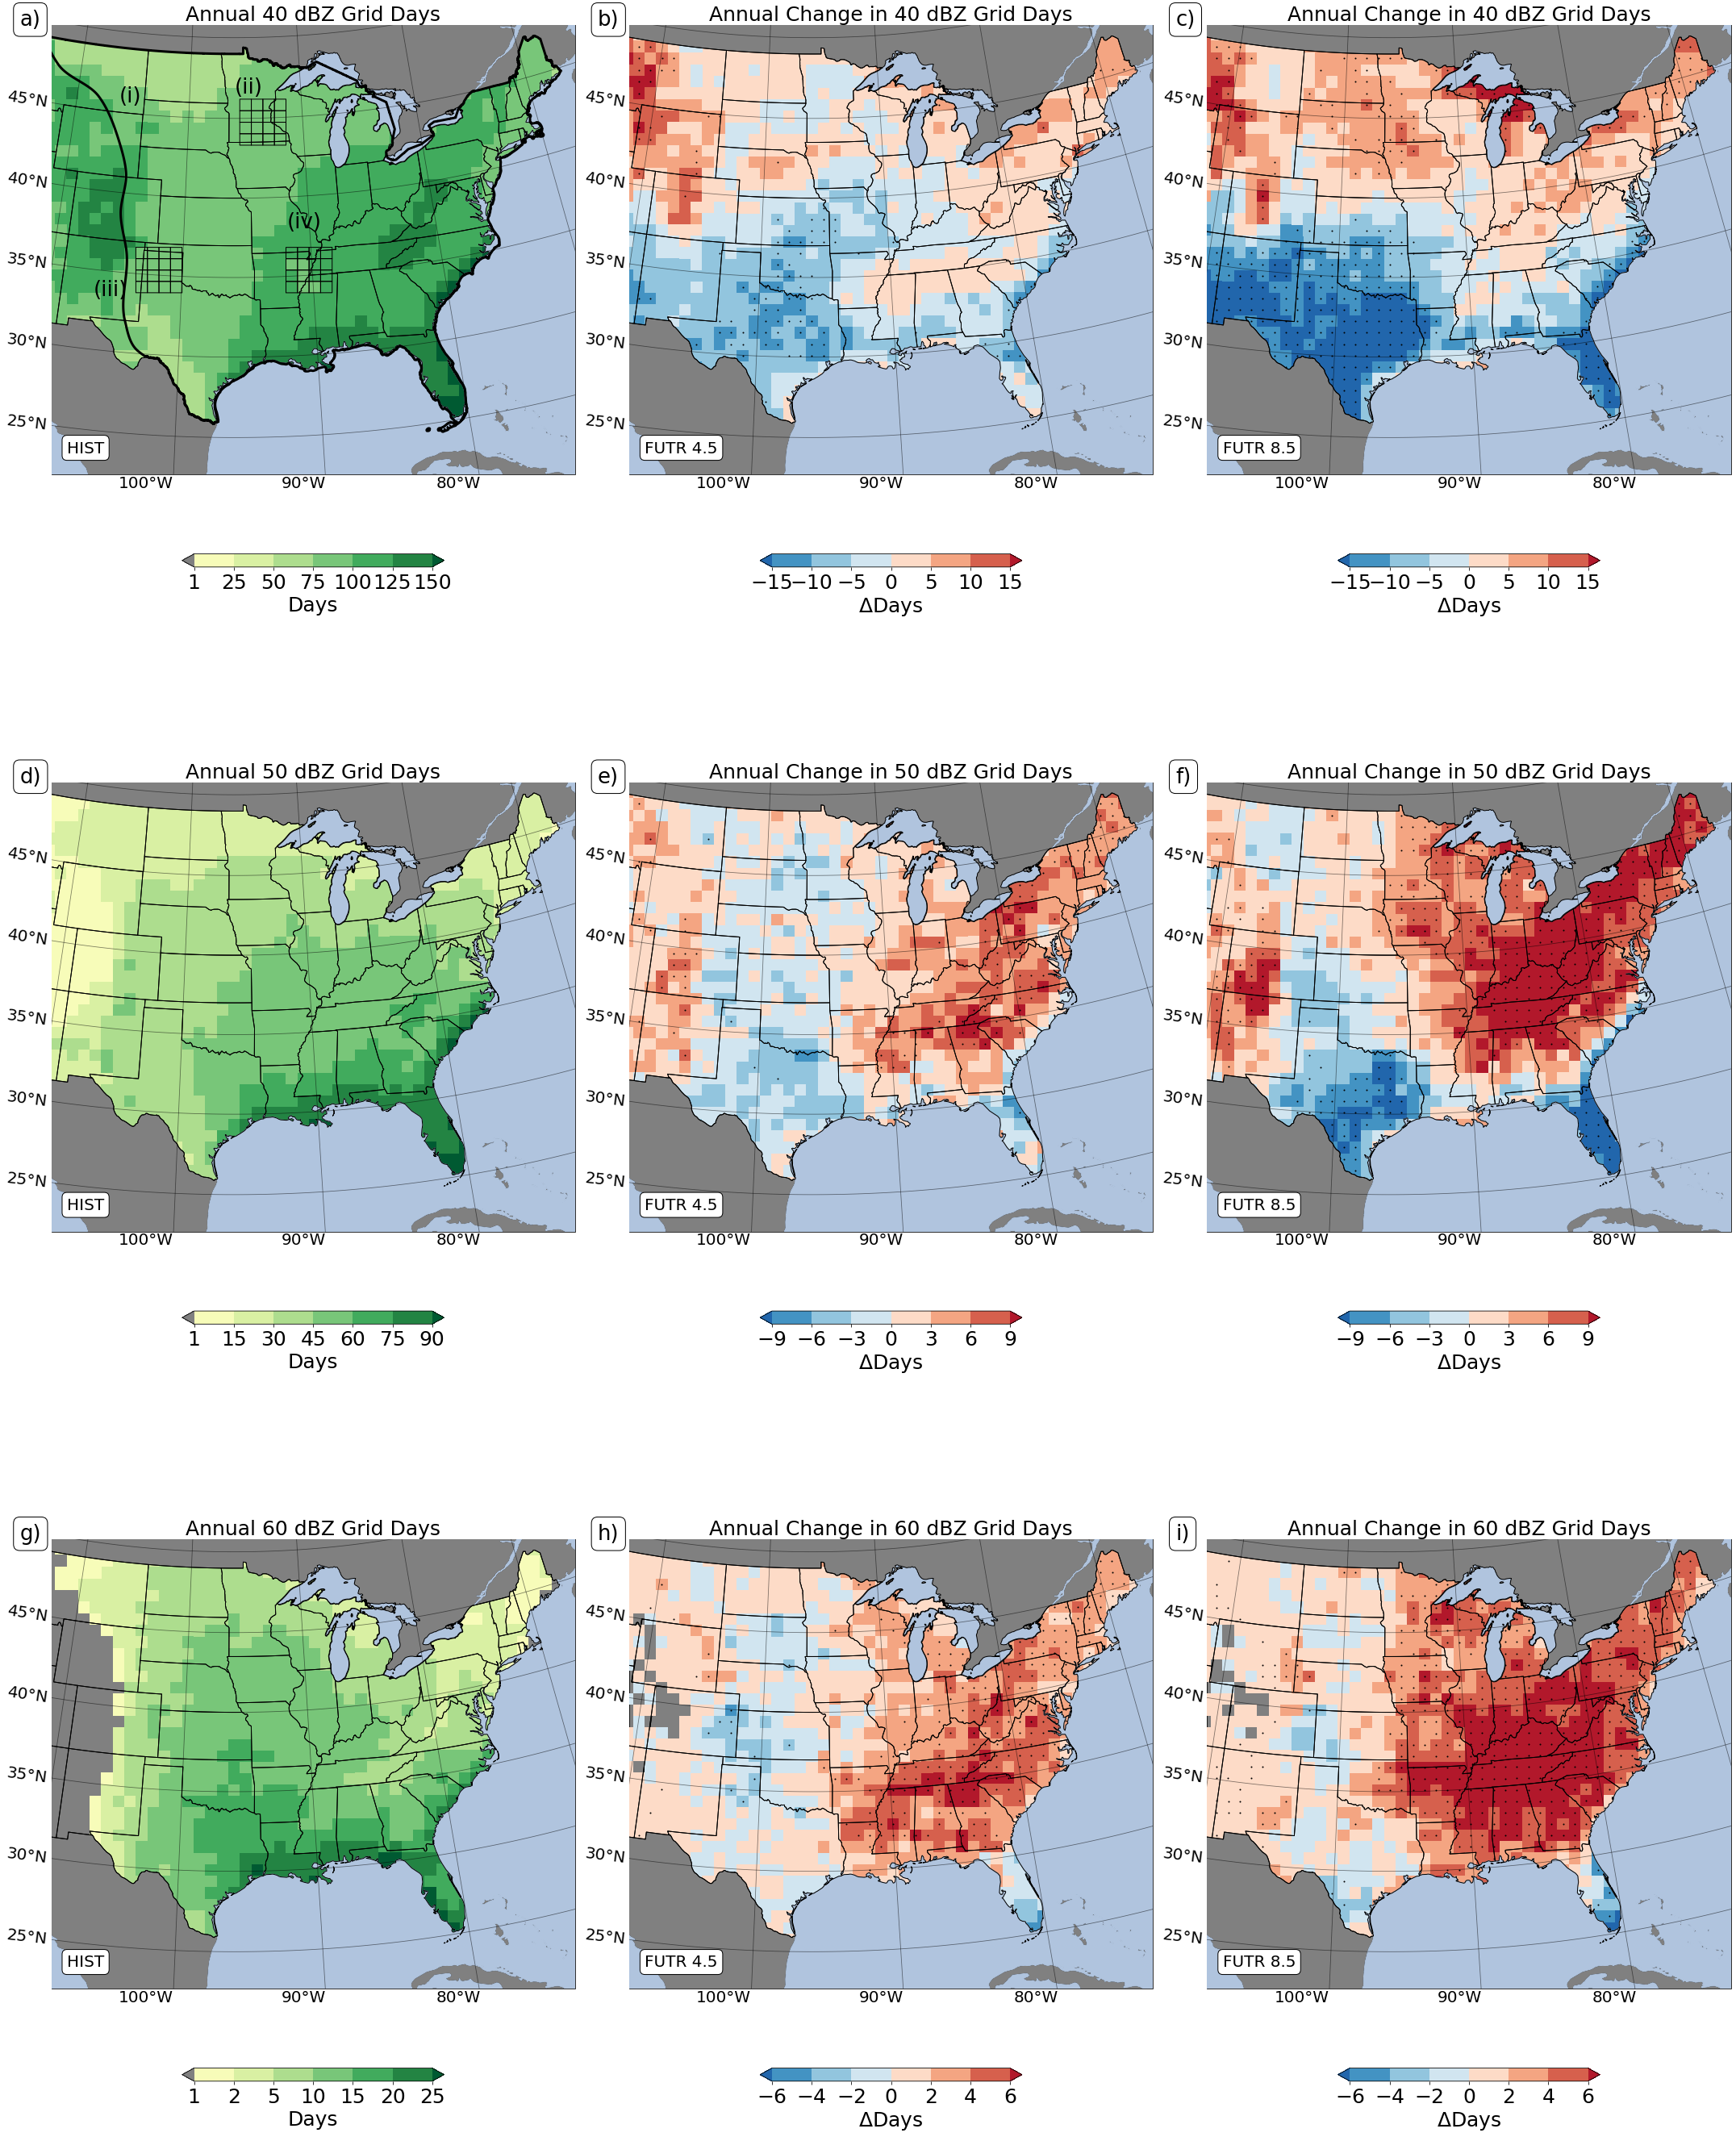

In [11]:
import numpy as np
import cartopy.crs as ccrs
from grl2022.mapping.geog import grid_significance

plt.rcParams['figure.figsize'] = 30, 40

hist_s = hist.resample(time='AS-OCT').sum('time')
rcp45_s = rcp45.resample(time='AS-OCT').sum('time')
rcp85_s = rcp85.resample(time='AS-OCT').sum('time')

for row, dbz in enumerate([40, 50, 60]):
    
    hist_dbz_ind = hist_s[f'{dbz}_dbz_count']
    rcp45_dbz_ind = rcp45_s[f'{dbz}_dbz_count']
    rcp85_dbz_ind = rcp85_s[f'{dbz}_dbz_count']
    
    pts45 = np.where(grid_significance(hist_dbz_ind.values, rcp45_dbz_ind.values) < 0.05)
    pts85 = np.where(grid_significance(hist_dbz_ind.values, rcp85_dbz_ind.values) < 0.05)
    
    hist_dbz = hist_dbz_ind.mean('time')
    rcp45_dbz = rcp45_dbz_ind.mean('time')
    rcp85_dbz = rcp85_dbz_ind.mean('time')

    rcp45_diff = rcp45_dbz - hist_dbz
    rcp85_diff = rcp85_dbz - hist_dbz

    rcp45_diff = np.ma.masked_where((rcp45_dbz==0) & (hist_dbz==0), rcp45_diff)
    rcp85_diff = np.ma.masked_where((rcp85_dbz==0) & (hist_dbz==0), rcp85_diff)


    sig = {'HIST': {'x': [], 'y': []}}
    sig['FUTR 4.5'] = {'x': gx[pts45], 'y': gy[pts45]}
    sig['FUTR 8.5'] = {'x': gx[pts85], 'y': gy[pts85]}

    for col, (name, sim) in enumerate(zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], 
                                          [hist_dbz, rcp45_diff, rcp85_diff])):

        ax = setup_map(row, col, 3, 3)
        
        if name=='HIST' and dbz==40:
            
            ax.add_geometries(econus['geometry'], crs=ccrs.PlateCarree(), facecolor='None', 
                              edgecolor='k', linewidths=3, zorder=10)
            ax.add_geometries(sel_grids['ama']['geometry'], crs=ccrs.PlateCarree(), facecolor='None', 
                              edgecolor='k', linewidths=1, zorder=10)
            ax.add_geometries(sel_grids['mph']['geometry'], crs=ccrs.PlateCarree(), facecolor='None', 
                              edgecolor='k', linewidths=1, zorder=10)
            ax.add_geometries(sel_grids['mnp']['geometry'], crs=ccrs.PlateCarree(), facecolor='None', 
                              edgecolor='k', linewidths=1, zorder=10)
        
            ax.annotate("(i)", (.13,.83), xycoords='axes fraction', fontsize=26, color='k', zorder=20)
            ax.annotate("(ii)", (.35,.85), xycoords='axes fraction', fontsize=26, color='k', zorder=20)
            ax.annotate("(iii)", (0.08,.4), xycoords='axes fraction', fontsize=26, color='k', zorder=20)
            ax.annotate("(iv)", (.45,.55), xycoords='axes fraction', fontsize=26, color='k', zorder=20)

        ax.set_title(titles[name]['title'].format("Annual", dbz), fontsize=25)

        norm, cmap = get_cmap(name, f"{dbz} Grid Days")

        mmp = ax.pcolormesh(gx, gy, sim, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='nearest', zorder=5)
        cbar = plt.colorbar(mmp, ax=ax, shrink=0.5, pad=0.1, orientation='horizontal', extend='both', label='Days')
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label(label=titles[name]['clabel'], size=25)   

        ax.plot(sig[name]['x'], sig[name]['y'], 'k.', ms=2, transform=ccrs.PlateCarree(), zorder=5)
        
        ax.annotate(name, (0.03,0.05), xycoords='axes fraction',fontsize=20, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
        
plt.tight_layout()

plt.savefig("../figures/fig1.pdf", bbox_inches='tight', dpi=300) 